<a href="https://colab.research.google.com/github/SovetovAleksey/PyTorch/blob/main/HW_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets, models

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
dataset = datasets.CIFAR100(root='data/',
                            train=True,
                            download=True)

Files already downloaded and verified


In [ ]:
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test


class MyOwnCifar(torch.utils.data.Dataset):

    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]  #извлекаем картинку
        if self.transform is not None:
            img = self.transform(img)
        label = self._base_dataset[idx][1] #извлекаем класс
        return img, label

trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor()])

In [ ]:
train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

#итераторы для работы с датасетом
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.s1 = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 64, 3),
            nn.MaxPool2d(2),
            nn.LeakyReLU()

        )
        self.s2 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3),
            nn.MaxPool2d(2),
            nn.LeakyReLU()
        )
        self.s3 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )
        self.s4 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 100)
        )

    def forward(self, x):
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = x.view(x.size(0), -1)
        x = self.s4(x)

        return x

In [ ]:
def train_val_net(net, epochs, train_loader, valid_loader, optimozer, criterion):
    train_acc = []
    valid_acc = []

    for epoch in range(epochs):
        net.train()
        running_loss, running_items, running_right = 0.0, 0.0, 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_items += len(labels)
            running_right += (labels == torch.max(outputs, 1)[1]).sum()

        acc = running_right / running_items
        train_acc.append(acc)

        net.eval()
        for i, (valid_inputs, valid_labels) in enumerate(valid_loader):
            running_items_valid, running_right_valid = 0.0, 0.0
            valid_outputs = net(valid_inputs)
            running_items_valid += len(labels)
            running_right_valid += (valid_labels == torch.max(valid_outputs, 1)[1]).sum()

        acc = running_right_valid / running_items_valid
        valid_acc.append(acc)

    print('Training is finished!')
    return train_acc, valid_acc

In [ ]:
net = Net()
optimizer = torch.optim.Adamax(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 5
print(net)

Net(
  (s1): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (s2): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (s3): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (s4): Sequent

In [ ]:
train_acc, valid_acc = train_val_net(net, epochs, train_loader, valid_loader, optimizer, criterion)

Training is finished!


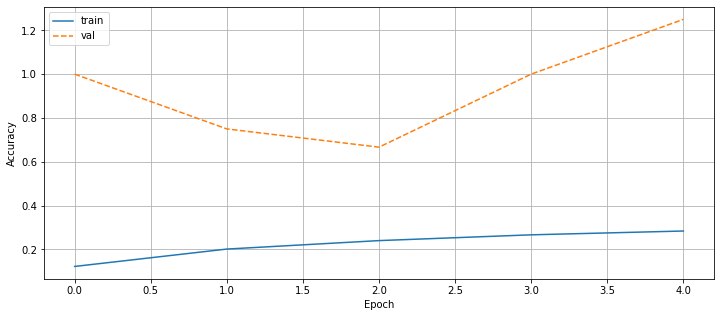

In [ ]:
plt.figure(figsize = (12,5))
plt.plot(train_acc,'-', label='train')
plt.plot(valid_acc,'--', label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()